<a href="https://colab.research.google.com/github/atanilson/Comp702_Final/blob/main/Comp702_Modular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Libraries

In [ ]:
# Geeting Files from GIt HUB

In [ ]:
"""
from functools import partial
import requests
from pathlib import Path

SCRIPTS_FOLDER = Path("scripts")
SCRIPTS_FOLDER.mkdir(parents=True,
                     exist_ok=True)

# URl of raw file in git hub
get_data_url = "https://raw.githubusercontent.com/atanilson/Comp702/refs/heads/main/scripts/get_data.py"
CNN_Model1_url = "https://raw.githubusercontent.com/atanilson/Comp702/refs/heads/main/scripts/CNN_Model1.py"
data_setup_url = "https://raw.githubusercontent.com/atanilson/Comp702/refs/heads/main/scripts/data_setup.py"
engine_url = "https://raw.githubusercontent.com/atanilson/Comp702/refs/heads/main/scripts/engine.py"
Main_script_url = "https://raw.githubusercontent.com/atanilson/Comp702/refs/heads/main/scripts/Main_script.py"
utils_url = "https://raw.githubusercontent.com/atanilson/Comp702/refs/heads/main/scripts/utils.py"

request = requests.get(get_data_url)
with open("scripts/get_data.py","wb") as f:
  f.write(request.content)
"""

In [ ]:
%%capture
!mkdir scripts
!wget https://raw.githubusercontent.com/atanilson/Comp702/refs/heads/main/scripts/get_data.py
!wget https://raw.githubusercontent.com/atanilson/Comp702/refs/heads/main/scripts/CNN_Model1.py
!wget https://raw.githubusercontent.com/atanilson/Comp702/refs/heads/main/scripts/data_setup.py
!wget https://raw.githubusercontent.com/atanilson/Comp702/refs/heads/main/scripts/engine.py
!wget https://raw.githubusercontent.com/atanilson/Comp702/refs/heads/main/scripts/Main_script.py
!wget https://raw.githubusercontent.com/atanilson/Comp702/refs/heads/main/scripts/utils.py
!mv get_data.py CNN_Model1.py data_setup.py engine.py Main_script.py utils.py scripts/
#!unzip scripts.zip

In [ ]:
import os
import torch
from scripts import data_setup, engine, utils, get_data
from timeit import default_timer as timer

from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'

In [ ]:
#!nvidia-smi

Sat Aug  2 09:05:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
get_data.download()

In [ ]:
#!rm -r "data/EuroSAT_RGB/River"

In [ ]:
!rm -r "data/EuroSAT_RGB/SeaLake"

In [ ]:
# Setup hyperparameters
NUM_EPOCHS = 150
BATCH_SIZE = 32
TEST_SPLIT = 0.2
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

# Setup directories
data_dir = "data/EuroSAT_RGB"

size_cut = 224

# Create tranforms Train
transform_train = transforms.Compose([
    transforms.Resize(size_cut),
    transforms.RandomResizedCrop(size_cut),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.RandomHorizontalFlip(),
    #****transforms.RandomRotation(10),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create tranforms test
transform_test = transforms.Compose([
    transforms.Resize(size_cut),
    transforms.CenterCrop(size_cut),
    #transforms.RandomHorizontalFlip(),
    #****transforms.RandomRotation(10),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


## Test transform onlr resise and normilize


# Create dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders2(dataset_dir="data/EuroSAT_RGB",
                                                                               train_transform=transform_train,
                                                                               test_transform=transform_test,
                                                                               batch_size=BATCH_SIZE,
                                                                               test_split = TEST_SPLIT,
                                                                               #random_seed = 42,
                                                                               #num_workers = 1
                                                                               )

In [ ]:
class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River']

In [ ]:
## MODEL

###model = - instatiate wterever
from torchvision.models import resnet50, ResNet50_Weights
from scripts import CNN_Model1

model_2 = resnet50(weights=ResNet50_Weights.DEFAULT)
model_2.fc = torch.nn.Linear(in_features=model_2.fc.in_features, out_features=len(class_names))
model_2 = model_2.to(device)

"""
model_1 = CNN_Model1.CNN_Model1(
    input_shape=3,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)
"""

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s]


'\nmodel_1 = CNN_Model1.CNN_Model1(\n    input_shape=3,\n    hidden_units=10,\n    output_shape=len(class_names)\n).to(device)\n'

In [ ]:
## LOSS FUNCTION OPTMIZER
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=LEARNING_RATE)

start_time = timer()
trained_model, results = engine.train(model=model_2, #Change to train next time I will change on the script
             train_dataloader = train_dataloader,
             test_dataloader = test_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             epochs = NUM_EPOCHS,
             device=device)
end_time = timer()

time_taken = end_time-start_time

print(f"Total training time:{end_time-start_time:.3f} seconds")

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.9153, Train Acc: 41.2135% | Test loss:1.6550, Test acc: 56.6458%
Epoch: 1 | Train loss: 1.2893, Train Acc: 64.5365% | Test loss:1.1056, Test acc: 69.9375%
Epoch: 2 | Train loss: 0.9266, Train Acc: 72.6719% | Test loss:0.7989, Test acc: 78.0417%
Epoch: 3 | Train loss: 0.7505, Train Acc: 76.8073% | Test loss:0.5872, Test acc: 83.4375%
Epoch: 4 | Train loss: 0.6355, Train Acc: 79.7812% | Test loss:0.5049, Test acc: 85.1875%
Epoch: 5 | Train loss: 0.5585, Train Acc: 82.0521% | Test loss:0.3886, Test acc: 88.6458%
Epoch: 6 | Train loss: 0.5084, Train Acc: 83.4271% | Test loss:0.3508, Test acc: 89.6042%
Epoch: 7 | Train loss: 0.4626, Train Acc: 85.1302% | Test loss:0.3119, Test acc: 90.7083%
Epoch: 8 | Train loss: 0.4423, Train Acc: 85.6510% | Test loss:0.2768, Test acc: 91.8542%
Epoch: 9 | Train loss: 0.4029, Train Acc: 87.0729% | Test loss:0.2512, Test acc: 92.5833%
Epoch: 10 | Train loss: 0.3884, Train Acc: 87.2344% | Test loss:0.2295, Test acc: 92.7917%
Epoch: 11

In [ ]:
type(trained_model)

scripts.CNN_Model1.CNN_Model1

In [ ]:
save_dir = "./drive/My Drive/Colab Notebooks/Comp702/Models/Retrained"

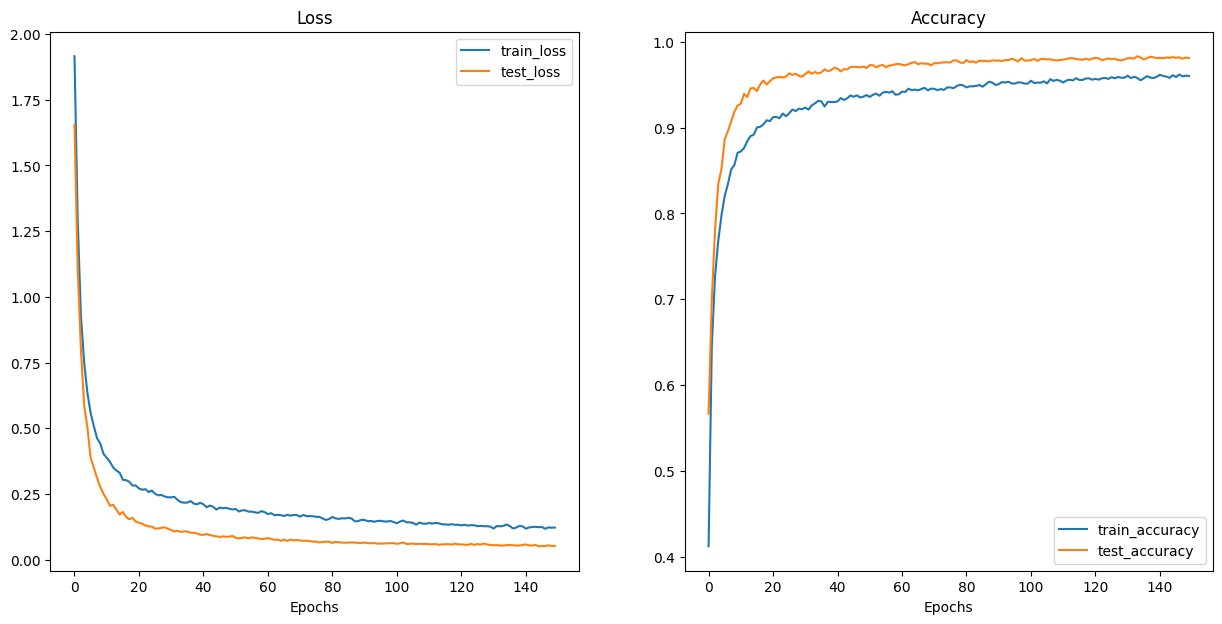

In [ ]:
utils.plot_loss_curves(results)

In [ ]:
#
utils.save_model(model=trained_model,
                 target_dir = save_dir,
                 model_name="RESNET50_0001_SDG-RGB_B32_WW_EP150_S224_9CL.pth")

#
utils.save_results(results=results,
                   optimizer="SDG",
                   lr="0_001",
                   model="RESNET50_RGB_B32_WW_EP150_S224_9CL",
                   time=time_taken,
                   save_dir=save_dir)

[INFO] Saving model to: drive/My Drive/Colab Notebooks/Comp702/Models/Retrained/RESNET50_0001_SDG-RGB_B32_WW_EP150_S224_9CL.pth
Saving to ./drive/My Drive/Colab Notebooks/Comp702/Models/RetrainedRESNET50_RGB_B32_WW_EP150_S224_9CL_SDG_0_001.csv


In [ ]:
#
utils.save_results(results=results,
                   optimizer="ADAMmmmm",
                   lr="0_001",
                   model="MODEL_1_RGB",
                   time=time_taken,
                   save_dir=save_dir)